![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# German Traffic Sign Recognition
Multi-class, single-image classification

### Dataset
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. They cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Their benchmark has the following properties:

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database

#### Notes
- For this project, we have reduced the number of images. There are around 16,500+ images in the dataset provided. You can check “label_details” folder for getting information about the classes.
- If the model is taking too much time to get trained then you can reduce the number of classes. There are around 43 classes in the dataset, model should be trained on a minimum of 15 classes.

### Initialize ImageDataGenerator (5 Marks)
- Rescale the images
- Specify value for validation_split & get 75% data in training and 25% data in training

In [5]:
import tensorflow as tf
#tf.set_random_seed(42)

import keras
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.utils import class_weight
from collections import Counter

from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
#mounting

from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


In [8]:
#setting path
path = '/content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/'
os.chdir(os.path.dirname(os.path.abspath(path)))

print(os.getcwd())

/content/drive/My Drive/ColabNotebooks/CNN


In [ ]:
!ls -l ASSIGNMENT-Project2

total 192215
-rw------- 1 root root      8429 Sep 10 07:15 'CNN_R8_Project2_German traffic signs.ipynb'
-rw------- 1 root root 196818701 Sep 10 06:42 'Data - German Traffic Sign Recognition.rar'


In [ ]:
#!unrar x -Y "/content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/Data - German Traffic Sign Recognition.rar" "/content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/Data - German Traffic Sign Recognition/Data - German Traffic Sign Recognition/Train/32/00032_00007_00017.png      85%  OK 
Extracting  /content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/Data - German Traffic Sign Recognition/Data - German Traffic Sign Recognition/Train/32/00032_00007_00018.png      85%  OK 
Extracting  /content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/Data - German Traffic Sign Recognition/Data - German Traffic Sign Recognition/Train/32/00032_00007_00019.png      85%  OK 
Extracting  /content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/Data - German Traffic Sign Recognition/Data - German Traffic Sign Recognition/Train/32/00032_00007_00020.png      85%  OK 
Extracting  /content/drive/My Drive/ColabNotebooks/CNN/ASSIGNMENT-Project2/Data - German Traffic Sign Recognition/Data - 

In [9]:
#setting path and checking classes
train_path = 'ASSIGNMENT-Project2/Data-GermanTrafficSignRecognition/Data-GermanTrafficSignRecognition/Train'
test_path = 'ASSIGNMENT-Project2/Data-GermanTrafficSignRecognition/Data-GermanTrafficSignRecognition/Test'
os.listdir(test_path)

['Meta']

### Get training data from ImageDataGenerator (5 Marks)
- Give directory path
- Give target size
- Give batch_size
- Specify classes, if you wish to use less number of classes you need to give class names in a list (Atleast 15 classes should be there)
- Specify class_mode
- Specify color_mode
- Specify subset

You can get details here
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [10]:
#Define some parameters
img_size = 64
img_depth = 3

In [24]:
#ImageDataGenerator declaration with 25% data as test (75% for training)
img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,
                                                               horizontal_flip=True,                                                              
                                                               vertical_flip = True,                                                               
                                                               validation_split=0.25)

In [25]:
#Build training generator. 
train_generator = img_generator.flow_from_directory(train_path,
                                                    target_size=(img_size, img_size),
                                                    color_mode="rgb",
                                                    subset='training',
                                                    class_mode="categorical",
                                                    classes=['0','1','2','3','10','11','12','13','14','15','16','17','18','19','20','21'],
                                                    batch_size=64,
                                                    shuffle=True,
                                                    seed=42)

Found 14043 images belonging to 16 classes.


### Get validation data from ImageDataGenerator (5 Marks)
- Give directory path
- Give target size
- Give batch_size
- Specify classes, if you wish to use less number of classes you need to give class names in a list (Atleast 15 classes should be there)
- Specify class_mode
- Specify color_mode
- Specify subset

You can get details here
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [26]:
#Build validation generator
validation_generator = img_generator.flow_from_directory(train_path,
                                                   target_size=(img_size, img_size),   
                                                   color_mode="rgb",                                                
                                                   subset='validation',
                                                   class_mode="categorical",
                                                   classes=['0','1','2','3','10','11','12','13','14','15','16','17','18','19','20','21'],
                                                   batch_size=64,
                                                   shuffle=True,
                                                   seed=42)

Found 4676 images belonging to 16 classes.


In [27]:
test_generator = img_generator.flow_from_directory(test_path,
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode=None,
    batch_size=1    
)

Found 23 images belonging to 1 classes.


### Define model (5 Marks)
- Initialize a Sequential Model
- Add Convolution, Maxpool, Dropout, Flatten & Dense layers according to your model architecture

In [28]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#normalize data
model.add(BatchNormalization(input_shape=(img_size,img_size,3,)))

#Add Conv Layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(tf.keras.layers.Dense(16, activation='softmax'))


### Compile the model (2 Marks)
- Specify optimizer, loss & metrics

In [29]:
#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = Adam(lr=0.002)

#Specify Loass and Optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

model_checkpoint =  ModelCheckpoint('German_Traffic_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

### Get model summary (2 Marks)

In [31]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 64)        2

In [32]:
itemCt = Counter(train_generator.classes)
maxCt = float(max(itemCt.values()))
cw = {clsID : maxCt/numImg for clsID, numImg in itemCt.items()}

In [33]:
cw

{0: 10.683544303797468,
 1: 1.0138138138138137,
 2: 1.0,
 3: 1.5954631379962192,
 4: 1.1201061712010618,
 5: 1.7050505050505051,
 6: 1.0717460317460317,
 7: 1.0419753086419754,
 8: 2.8854700854700854,
 9: 3.568710359408034,
 10: 5.358730158730158,
 11: 2.0264105642256904,
 12: 1.8755555555555556,
 13: 10.683544303797468,
 14: 6.2518518518518515,
 15: 6.806451612903226}

### Fit the model (3 Marks)
- Specify epochs
- Specify batch_size
- Give validation_data
- Validation accuracy should be more than 90%

In [34]:
history = model.fit_generator(train_generator, 
                          epochs=200,
                          #steps_per_epoch= 22124//64,  #Number of training images//batch_size
                          steps_per_epoch = 14043//64,  #Number of training images//batch_size
                          validation_data = validation_generator,
                          #validation_steps = 7364//64,
                          validation_steps = 4676//64,
                          class_weight = cw,
                          callbacks = [model_checkpoint]
                    ) #Number of test images//batch_size

Epoch 1/200
219/219 [==============================] - ETA: 0s - loss: 5.5840 - accuracy: 0.1532
Epoch 00001: val_loss improved from inf to 2.95519, saving model to German_Traffic_01_loss2.9552.h5
219/219 [==============================] - 46s 210ms/step - loss: 5.5840 - accuracy: 0.1532 - val_loss: 2.9552 - val_accuracy: 0.0666
Epoch 2/200
219/219 [==============================] - ETA: 0s - loss: 4.1502 - accuracy: 0.2652
Epoch 00002: val_loss improved from 2.95519 to 2.34603, saving model to German_Traffic_02_loss2.3460.h5
219/219 [==============================] - 45s 207ms/step - loss: 4.1502 - accuracy: 0.2652 - val_loss: 2.3460 - val_accuracy: 0.2620
Epoch 3/200
219/219 [==============================] - ETA: 0s - loss: 3.3212 - accuracy: 0.3725
Epoch 00003: val_loss did not improve from 2.34603
219/219 [==============================] - 45s 208ms/step - loss: 3.3212 - accuracy: 0.3725 - val_loss: 2.3887 - val_accuracy: 0.2295
Epoch 4/200
219/219 [==============================]

In [35]:
# evaluate model
model.evaluate_generator(validation_generator)

[0.39195287227630615, 0.9183062314987183]

### Draw plots (3 Marks)
- Plot training accuracy and validation accuracy with respect to epochs
- Plot training loss and validation loss with respect to epochs

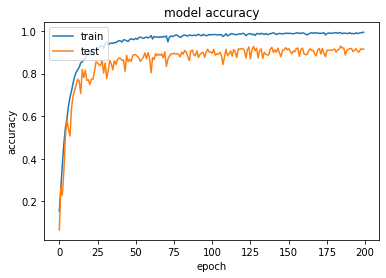

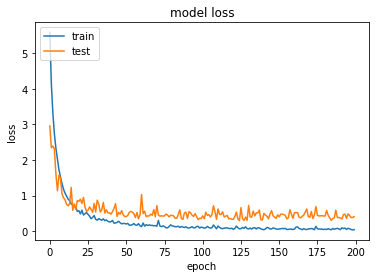

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
print('Epoch 125 given the best val_accuracy - 0.9251')

Epoch 125 given the best val_accuracy - 0.9251
